# Line of Sight (LOS) Module Research

This notebook explores the implementation of line-of-sight calculations between two geographic coordinates using elevation data. The goal is to develop and validate LOS logic before integrating it into the main Sport Radar application.

This notebook will use a simple python virtual environment. The required dependencies are listed in `los_module/requirements.txt`. You can create the virtual environment and install the dependencies using the following commands (assuming you are already in the `los_module` directory):

```bash
python -m venv .venv
source .venv/bin/activate  # On Windows, use .venv\Scripts\activate
pip install -r requirements.txt
```

## Objectives

1. Load and work with Copernicus DEM data (GLO-30)
2. Calculate line of sight between two geographic coordinates
3. Produce output that can be visualized in the main app's ARView

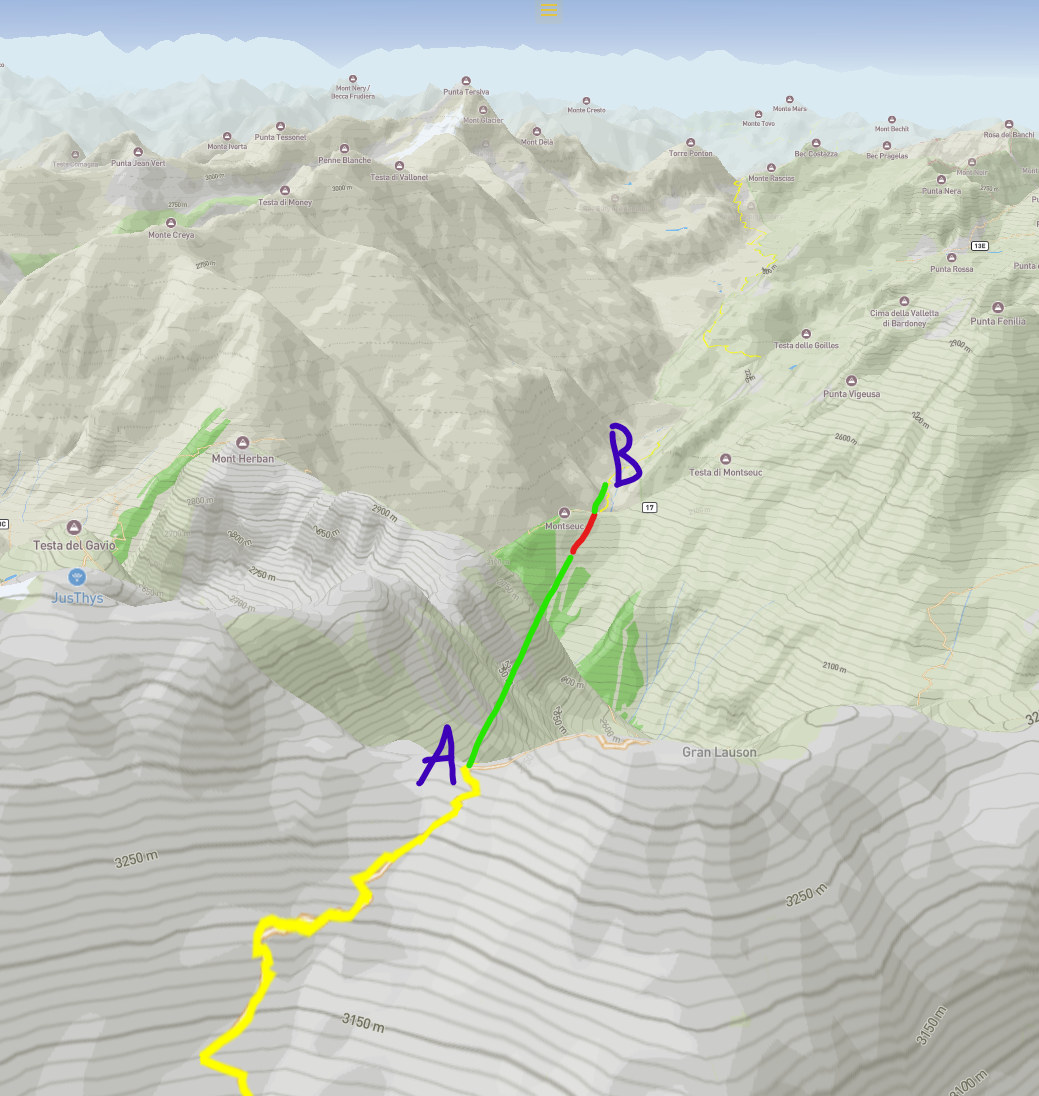
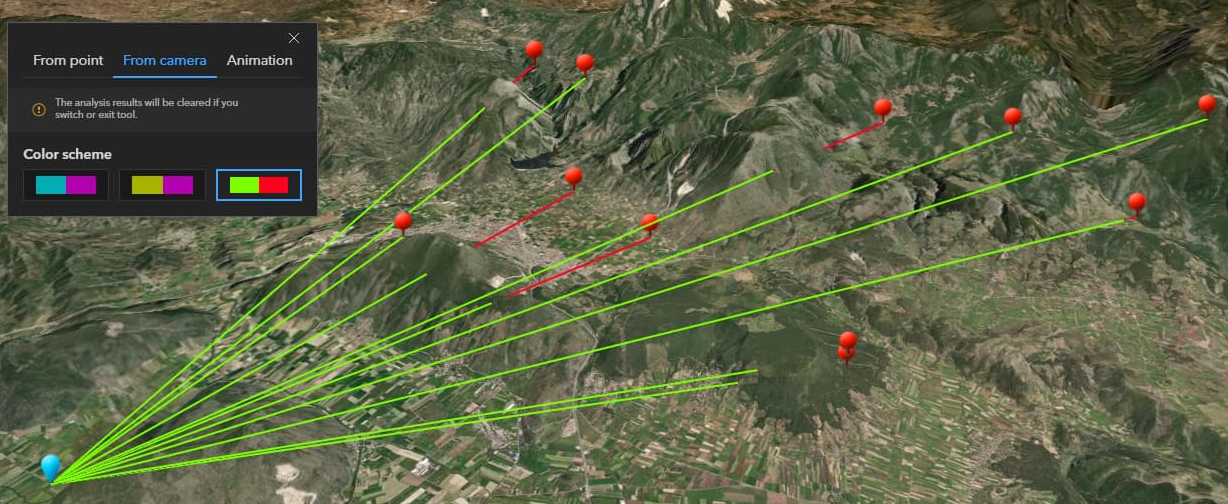
Something like this

## Study Area

The TOR330 ultra-trail race route in the Italian/French Alps (Aosta Valley area). This is the same region used in the main application, allowing us to validate results against the existing terrain visualization.

---
## Phase 1: Raw DEM Files (Copernicus DEM)

We start with raw DEM files because:
- Direct access to elevation values without decoding tile formats
- Well-documented GeoTIFF format with standard tooling (rasterio, GDAL)
- No API rate limits or authentication complexity
- Easier to debug and validate results

### Copernicus DEM Resolutions
- **GLO-30**: 30m resolution, freely available globally
- **GLO-90**: 90m resolution, freely available globally

We'll use GLO-30 for better accuracy in the mountainous terrain.

### 1.1 Environment Setup & Imports

In [1]:
import os
import sys
import fiona
#import rasterio

# Fix PROJ database conflict: rasterio requires proj.db MINOR >= 5, but pyproj
# and PostgreSQL/PostGIS ship older versions that get picked up first.
# Point PROJ_DATA at rasterio's bundled proj_data which has the newest version.
_proj_data = os.path.join(
    sys.prefix, "Lib", "site-packages", "rasterio", "proj_data"
)
if os.path.isdir(_proj_data):
    os.environ["PROJ_DATA"] = _proj_data

import leafmap.leafmap as leafmap
print("localtileserver")

localtileserver


### 1.2 Download/Load Copernicus DEM Data

Copernicus DEM tiles can be downloaded from:
- [Copernicus Open Access Hub](https://spacedata.copernicus.eu/)
- [OpenTopography](https://opentopography.org/)
- AWS Open Data Registry

For the TOR330 area, we need tiles covering approximately:
- Latitude: 45.5°N to 46.0°N
- Longitude: 6.8°E to 7.5°E

### 1.3 Explore the DEM Data

In [2]:
# TODO: Inspect DEM
# TODO: Print basic statistics (min/max elevation, shape)
import geopandas as gpd

dem = "DEM.tif"
m = leafmap.Map()
m.add_raster(dem, colormap="terrain", layer_name="DEM")

tracks = gpd.read_file("TOR330-CERT-2025.gpx", layer="tracks")
m.add_gdf(tracks, layer_name="TOR330 Route", style={"color": "red", "weight": 3})
m

Map(center=[45.7141675, 7.421983], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [3]:
from whitebox import WhiteboxTools
from shapely.geometry import Point
import rasterio

# 1. Get marker coordinates from the map
assert m.draw_features, "No marker drawn! Add a marker on the map above, then re-run this cell."
coords = m.draw_features[-1]["geometry"]["coordinates"]  # last drawn marker
marker_lng, marker_lat = coords[0], coords[1]
print(f"Observer position (WGS84): lng={marker_lng:.6f}, lat={marker_lat:.6f}")

# 2. Create station point and reproject to match DEM CRS (EPSG:25832)
station_gdf = gpd.GeoDataFrame(
    {"id": [1]},
    geometry=[Point(marker_lng, marker_lat)],
    crs="EPSG:4326",
).to_crs("EPSG:25832")

print(f"Reprojected to EPSG:25832: x={station_gdf.geometry.iloc[0].x:.1f}, y={station_gdf.geometry.iloc[0].y:.1f}")

station_file = os.path.abspath("viewshed_station.shp")
station_gdf.to_file(station_file)

# 3. Run viewshed analysis
dem_path = os.path.abspath("DEM.tif")
output_path = os.path.abspath("viewshed_result.tif")

wbt = WhiteboxTools()
wbt.work_dir = os.path.abspath(".")
wbt.verbose = True
wbt.viewshed(
    dem=dem_path,
    stations=station_file,
    output=output_path,
    height=1.7,
)

assert os.path.exists(output_path), "Viewshed output not created. Check WhiteboxTools output above."

# 4. Post-process: set non-visible (0) as nodata for transparency
with rasterio.open(output_path) as src:
    data = src.read(1)
    profile = src.profile.copy()

profile.update(nodata=0)
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(data, 1)

# 5. Overlay on map — visible areas shown in green
m.add_raster(output_path, colormap="Greens", layer_name="Viewshed", opacity=0.5)
print("Viewshed computed and displayed (green = visible from marker).")

Observer position (WGS84): lng=7.329941, lat=45.584011
Reprojected to EPSG:25832: x=369718.2, y=5049186.4
.\whitebox_tools.exe --run="Viewshed" --wd="c:\Users\lpn\Random\trailradar\los_module" --dem='c:\Users\lpn\Random\trailradar\los_module\DEM.tif' --stations='c:\Users\lpn\Random\trailradar\los_module\viewshed_station.shp' --output='c:\Users\lpn\Random\trailradar\los_module\viewshed_result.tif' --height=1.7 -v --compress_rasters=False

****************************
* Welcome to Viewshed      *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Locating view stations: 0%
Station 1 of 1
Calculating view angle (Station 1 of 1): 1%
Calculating view angle (Station 1 of 1): 2%
Calculating view angle (Station 1 of 1): 3%
Calculating view angle (Station 1 of 1): 4%
Calculating view angle (Station 1 of 1): 5%
Calculating view angle (Station 1 of 1): 6%
Calculating view angle (Station 1 of 1): 7%
Calculating view angle (Station 1 of 1): 8%
Cal

In [4]:
# New map showing viewshed analysis results
from ipyleaflet import Marker, AwesomeIcon
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import numpy as np

# Read viewshed with rioxarray and reproject to EPSG:4326
import rioxarray
vs = rioxarray.open_rasterio("viewshed_result.tif").squeeze()
vs = vs.rio.reproject("EPSG:4326")
bounds = vs.rio.bounds()  # (left, bottom, right, top)

# Create a transparent PNG overlay: visible=green, non-visible=transparent
data = vs.values
h, w = data.shape
rgba = np.zeros((h, w, 4), dtype=np.uint8)
visible = data == 1
rgba[visible] = [0, 200, 0, 180]  # green, semi-transparent

img_path = "viewshed_overlay.png"
Image.fromarray(rgba).save(img_path)

# Display on map using image overlay
from ipyleaflet import ImageOverlay
import base64

with open(img_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()
data_url = f"data:image/png;base64,{b64}"

m2 = leafmap.Map()
m2.add_raster("DEM.tif", colormap="terrain", layer_name="DEM", opacity=0.7)

overlay = ImageOverlay(
    url=data_url,
    bounds=((bounds[1], bounds[0]), (bounds[3], bounds[2])),  # ((south, west), (north, east))
    name="Viewshed",
)
m2.add(overlay)

m2.add_gdf(tracks, layer_name="TOR330 Route", style={"color": "red", "weight": 3})

icon = AwesomeIcon(name="eye", marker_color="red", icon_color="white")
obs_marker = Marker(location=(marker_lat, marker_lng), icon=icon, title="Observer")
m2.add(obs_marker)

m2

Map(center=[45.7141675, 7.421983], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [7]:
# Destriping for viewshed_result.tif
# WhiteboxTools' sector-sweep algorithm creates stripe artifacts at sector boundaries.
# Strategy: median filter (removes salt-and-pepper noise) + morphological closing (fills gaps).

from scipy.ndimage import median_filter, binary_closing, generate_binary_structure
import rasterio
import numpy as np
import scipy

with rasterio.open("viewshed_result.tif") as src:
    raw = src.read(1)
    profile = src.profile.copy()

binary = (raw == 1).astype(np.uint8)

# Step 1: 3x3 median filter — removes isolated 1-2px stripe noise
filtered = median_filter(binary, size=3)

# Step 2: morphological closing (dilation then erosion) with a 3x3 disk-like kernel
# Fills narrow gaps between stripe fragments while preserving the overall shape
struct = generate_binary_structure(2, 2)  # 3x3 connectivity-8 kernel
closed = binary_closing(filtered, structure=struct, iterations=1).astype(np.uint8)

# Compare before/after
orig_count = binary.sum()
clean_count = closed.sum()
print(f"Visible pixels — before: {orig_count:,}  after: {clean_count:,}  change: {clean_count - orig_count:+,} ({(clean_count/orig_count - 1)*100:+.1f}%)")

# Write destriped result
profile.update(nodata=0)
with rasterio.open("viewshed_destriped.tif", "w", **profile) as dst:
    dst.write(closed, 1)

print("Saved viewshed_destriped.tif")

Visible pixels — before: 19,309  after: 20,383  change: +1,074 (+5.6%)
Saved viewshed_destriped.tif


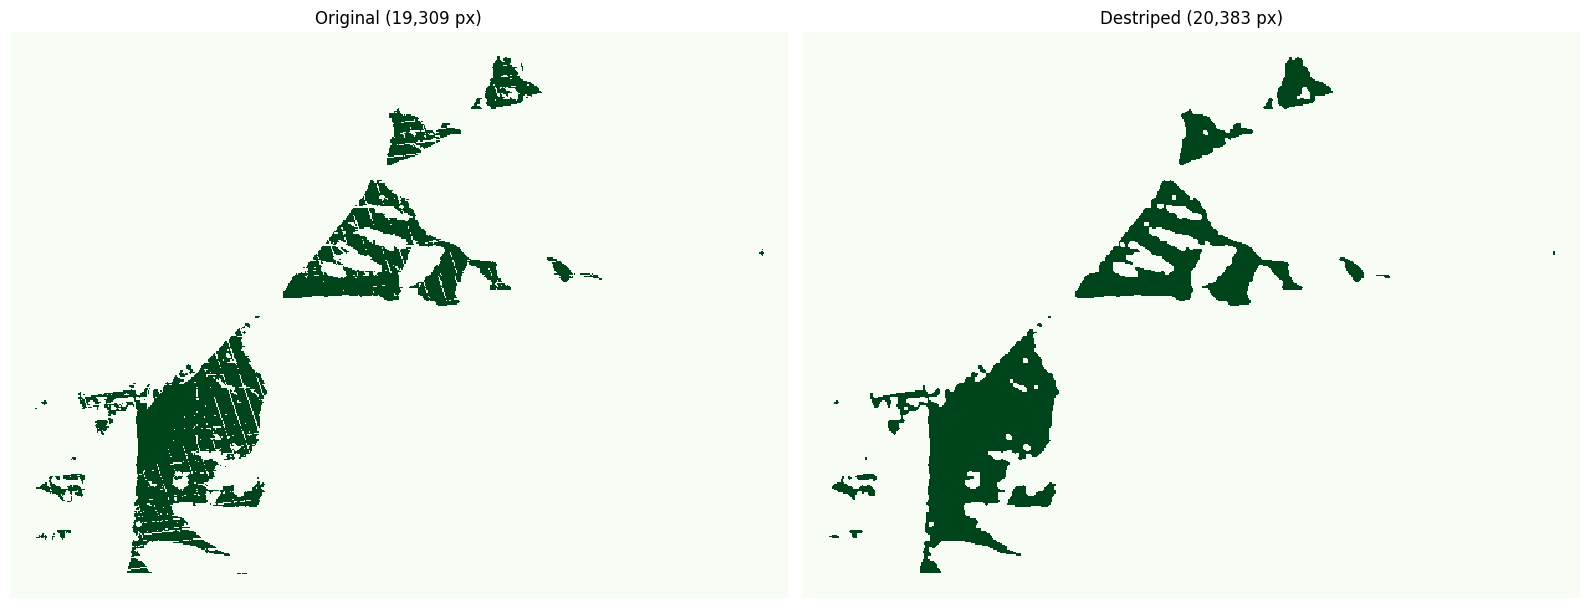

Saved comparison to viewshed_destrip_comparison.png


In [8]:
# Side-by-side comparison: original vs destriped viewshed
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Crop to the region with actual viewshed data for better comparison
rows = np.any(binary, axis=1)
cols = np.any(binary, axis=0)
rmin, rmax = np.where(rows)[0][[0, -1]]
cmin, cmax = np.where(cols)[0][[0, -1]]
pad = 20
rmin, rmax = max(0, rmin - pad), min(binary.shape[0], rmax + pad)
cmin, cmax = max(0, cmin - pad), min(binary.shape[1], cmax + pad)

axes[0].imshow(binary[rmin:rmax, cmin:cmax], cmap="Greens", interpolation="nearest")
axes[0].set_title(f"Original ({orig_count:,} px)")
axes[1].imshow(closed[rmin:rmax, cmin:cmax], cmap="Greens", interpolation="nearest")
axes[1].set_title(f"Destriped ({clean_count:,} px)")

for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.savefig("viewshed_destrip_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved comparison to viewshed_destrip_comparison.png")

### 1.4 Helper Functions for Coordinate-to-Elevation Lookup

In [9]:
# Display destriped viewshed on map (replaces the original overlay)
import rioxarray
from ipyleaflet import ImageOverlay, Marker, AwesomeIcon
from PIL import Image
import base64

vs_clean = rioxarray.open_rasterio("viewshed_destriped.tif").squeeze()
vs_clean = vs_clean.rio.reproject("EPSG:4326")
bounds = vs_clean.rio.bounds()

data_clean = vs_clean.values
h, w = data_clean.shape
rgba = np.zeros((h, w, 4), dtype=np.uint8)
rgba[data_clean == 1] = [0, 200, 0, 180]

img_path = "viewshed_overlay_destriped.png"
Image.fromarray(rgba).save(img_path)

with open(img_path, "rb") as f:
    b64 = base64.b64encode(f.read()).decode()
data_url = f"data:image/png;base64,{b64}"

m3 = leafmap.Map()
m3.add_raster("DEM.tif", colormap="terrain", layer_name="DEM", opacity=0.7)
overlay = ImageOverlay(
    url=data_url,
    bounds=((bounds[1], bounds[0]), (bounds[3], bounds[2])),
    name="Viewshed (destriped)",
)
m3.add(overlay)
m3.add_gdf(tracks, layer_name="TOR330 Route", style={"color": "red", "weight": 3})

icon = AwesomeIcon(name="eye", marker_color="red", icon_color="white")
m3.add(Marker(location=(marker_lat, marker_lng), icon=icon, title="Observer"))
m3

Map(center=[45.7141675, 7.421983], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [4]:
# TODO: Create function to get elevation at a given (lat, lng) coordinate
# - Convert geographic coordinates to pixel indices
# - Handle edge cases (out of bounds, nodata values)
# - Consider interpolation for sub-pixel accuracy

In [5]:
# TODO: Test elevation lookup with known points from the TOR330 route
# Compare with elevation values in the GeoJSON to validate

---
## 2. Line of Sight Calculation

The core LOS algorithm determines whether there is an unobstructed view between two points by:
1. Creating a line between observer and target
2. Sampling elevation along that line
3. Checking if any terrain point blocks the sightline

### 2.1 Basic LOS Algorithm

In [6]:
# TODO: Implement function to generate sample points along a line between two coordinates
# - Input: observer (lat, lng, height), target (lat, lng, height)
# - Output: list of (lat, lng) sample points

In [7]:
# TODO: Implement basic LOS calculation
# - For each sample point, get terrain elevation
# - Calculate the expected sightline height at that point
# - Check if terrain is above sightline (blocked) or below (visible)

In [8]:
# TODO: Test LOS with simple cases
# - Two points with clear view
# - Two points with mountain in between

### 2.2 Visualization of LOS Results

In [9]:
# TODO: Create elevation profile visualization
# - X-axis: distance along sightline
# - Y-axis: elevation
# - Show terrain profile and sightline
# - Highlight blocked/visible segments

In [10]:
# TODO: Create 2D map visualization
# - Show observer and target points
# - Draw line between them
# - Color-code based on visibility

### 2.3 Considerations for Accuracy

Factors that affect LOS accuracy:
- **Earth curvature**: significant for distances > 1km
- **Atmospheric refraction**: bends light slightly
- **DEM resolution**: 30m may miss small obstacles
- **Observer/target height**: eye level vs ground level

In [11]:
# TODO: Implement earth curvature correction
# Formula: curvature_drop = distance^2 / (2 * earth_radius)

In [12]:
# TODO: Add observer height parameter (e.g., 1.7m for eye level)

---
## 3. Output for Main Application

The LOS results need to be formatted for integration with the main app's ARView.

In [13]:
# TODO: Define output format
# - JSON structure for LOS result
# - Include: observer, target, visibility (bool), blocked_points (if any)

In [14]:
# TODO: Create function to export LOS results
# - Save to JSON file
# - Compatible with ARView coordinate system

---
## Phase 2: MapBox terrain-rgb Tiles (Future)

Once Phase 1 is complete, we can explore using MapBox terrain-rgb tiles to align with the main application.

### Elevation Encoding
MapBox terrain-rgb tiles encode elevation in RGB values:
```
height = -10000 + ((R * 256 * 256 + G * 256 + B) * 0.1)
```

This provides approximately -10,000m to +1,667,772m range with 0.1m precision.

In [15]:
# TODO (Future): Implement MapBox terrain-rgb tile fetching
# TODO (Future): Decode elevation from RGB values
# TODO (Future): Compare results with Copernicus DEM

---
## Summary & Next Steps

After completing this research:
1. Validate LOS calculations against known test cases
2. Optimize performance for real-time use
3. Integrate with main application's ARView
4. Consider caching/precomputation strategies for common viewpoints